In [1]:
from rdkit import Chem
 
SMILES_CHARS = [' ',
                  '#', '%', '(', ')', '+', '-', '.', '/',
                  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                  '=', '@',
                  'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                  'R', 'S', 'T', 'V', 'X', 'Z',
                  '[', '\\', ']',
                  'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                  't', 'u']
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
def smiles_encoder( smiles, maxlen=25 ):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles( smiles ))
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X
 
def smiles_decoder( X ):
    smi = ''
    X = X.argmax( axis=-1 )
    for i in X:
        smi += index2smi[ i ]
    return smi
    

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import rdkit
from rdkit import Chem
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from rdkit.Chem import AllChem


def smile_fingerprint(smile):
    mol = Chem.MolFromSmiles( smile )
    mfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fp = mfp.ToBitString()
    fp = fp + "00" # Hack: To pack properly, I need two more characters in the string
    m = np.array(list(fp)).astype(int) # Convert into list of chars, then into an array
    return m

# 'datasets/dd_train.csv'
def read_file(filename):
    #Load the dataset and extract target values
    mdf= pd.read_csv(filename)
    target = mdf['Binding Affinity']
    y = target.values
    mdf.drop(columns='Binding Affinity',inplace=True)
    
    return mdf, y


def create_mol2vec(mdf, model):
    

    mdf['mol'] = mdf['SMILES sequence'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
    mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
    mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]


    X = np.array([x.vec for x in mdf['mol2vec']])
    
    return X

def create_smilematrix(mdf):
    
    # Convert each SMILE into a matrix
    mat_list = list()
    for smiles in mdf['SMILES sequence']:
        m = smiles_encoder(smiles)
        mat_list.append(m)
    X = np.array(mat_list).reshape(len(mat_list), -1) # Flat array
    return X

def create_smile_fpmatrix(mdf):
    fpmat_list = list()
    for smiles in mdf['SMILES sequence']:
        m = smile_fingerprint(smiles)
        fpmat_list.append(m)
    X = np.array(fpmat_list).reshape(len(fpmat_list), -1) # Flat array
    return X

    


In [3]:
# Setup data for training

mol2vec_model = word2vec.Word2Vec.load('model_300dim.pkl')
mdf, y = read_file('datasets/dd_train.csv')
X1 = create_mol2vec(mdf, mol2vec_model)
X2 = create_smilematrix(mdf)
X3 = create_smile_fpmatrix(mdf)
print(X1.shape, X2.shape, X3.shape)
newX = np.concatenate((X1, X2, X3), axis = 1)
print(newX.shape)

(9000, 300) (9000, 1400) (9000, 2050)
(9000, 3750)


In [4]:
import a4ddcnn as q3
trainX = newX
#trainX = X

input_shape = (25, 150, 1) 
#input_shape = (25, 68, 1) 
#input_shape = (25, 56, 1) 


print(trainX.shape)
cnn_model, m, history = q3.do_naivecnn(trainX, y, input_shape)
#model, m, history = q3.do_naivecnn(X, y, input_shape)




Using TensorFlow backend.


(9000, 3750)
input_shape:  (25, 150, 1)
X shape:  (9000, 25, 150, 1)
Y shape:  (9000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 150, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 37, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14208)             0         
_________________________________

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


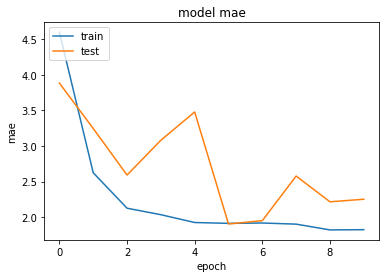

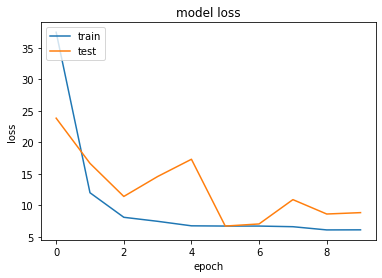

In [5]:
def show_history(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_history(history)

In [6]:
tdf, y = read_file('datasets/dd_test.csv')
mol2vec_model = word2vec.Word2Vec.load('model_300dim.pkl')

tX1 = create_mol2vec(tdf, mol2vec_model)
tX2 = create_smilematrix(tdf)
tX3 = create_smile_fpmatrix(tdf)

print(tX1.shape, tX2.shape)
testX = np.concatenate((tX1, tX2, tX3), axis = 1)
testX, input_shape1 = m.prepare_data_X(testX, input_shape)
predicted_values = cnn_model.predict(testX)
testy = pd.DataFrame((predicted_values), columns = ['Binding Affinity'])

print(tdf.columns)
tdf.drop(columns = ['mol', 'sentence', 'mol2vec'], inplace = True)

finaldf = pd.concat((tdf, testy), axis = 1)
print(finaldf.shape)

print(finaldf.columns)
finaldf.to_csv('dd_submission_cnn.csv')

(2500, 300) (2500, 1400)
Index(['SMILES sequence', 'mol', 'sentence', 'mol2vec'], dtype='object')
(2500, 2)
Index(['SMILES sequence', 'Binding Affinity'], dtype='object')


# Results from last good run
(9000, 3750)
input_shape:  (25, 150, 1)
X shape:  (9000, 25, 150, 1)
Y shape:  (9000,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 25, 150, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 37, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 64)         36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               442496    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
=================================================================
Total params: 533,633
Trainable params: 533,633
Non-trainable params: 0
_________________________________________________________________
Train on 7200 samples, validate on 1800 samples
Epoch 1/20
7200/7200 [==============================] - 58s 8ms/step - loss: 55.5932 - mae: 5.5568 - val_loss: 22.6516 - val_mae: 3.7313
Epoch 2/20
7200/7200 [==============================] - 87s 12ms/step - loss: 19.4019 - mae: 3.4127 - val_loss: 15.1286 - val_mae: 3.0294
Epoch 3/20
7200/7200 [==============================] - 85s 12ms/step - loss: 12.5443 - mae: 2.6963 - val_loss: 10.4033 - val_mae: 2.4266
Epoch 4/20
7200/7200 [==============================] - 83s 11ms/step - loss: 9.6886 - mae: 2.3373 - val_loss: 8.1866 - val_mae: 2.2320
Epoch 5/20
7200/7200 [==============================] - 73s 10ms/step - loss: 8.2332 - mae: 2.1467 - val_loss: 7.2007 - val_mae: 2.0545
Epoch 6/20
7200/7200 [==============================] - 84s 12ms/step - loss: 7.5180 - mae: 2.0398 - val_loss: 6.8609 - val_mae: 2.0071
Epoch 7/20
7200/7200 [==============================] - 72s 10ms/step - loss: 6.9995 - mae: 1.9619 - val_loss: 7.0522 - val_mae: 1.9566
Epoch 8/20
7200/7200 [==============================] - 67s 9ms/step - loss: 6.9479 - mae: 1.9536 - val_loss: 6.1796 - val_mae: 1.8792
Epoch 9/20
7200/7200 [==============================] - 63s 9ms/step - loss: 6.6526 - mae: 1.9061 - val_loss: 9.4901 - val_mae: 2.5381
Epoch 10/20
7200/7200 [==============================] - 66s 9ms/step - loss: 6.4855 - mae: 1.8962 - val_loss: 5.9078 - val_mae: 1.8191
Epoch 11/20
7200/7200 [==============================] - 68s 9ms/step - loss: 6.0949 - mae: 1.8197 - val_loss: 6.0675 - val_mae: 1.7952
Epoch 12/20
7200/7200 [==============================] - 63s 9ms/step - loss: 6.2217 - mae: 1.8488 - val_loss: 6.1045 - val_mae: 1.9150
Epoch 13/20
7200/7200 [==============================] - 70s 10ms/step - loss: 5.9454 - mae: 1.8018 - val_loss: 8.8777 - val_mae: 2.4508
Epoch 14/20
7200/7200 [==============================] - 68s 9ms/step - loss: 6.2097 - mae: 1.8471 - val_loss: 5.5430 - val_mae: 1.7719
Epoch 15/20
7200/7200 [==============================] - 66s 9ms/step - loss: 6.1398 - mae: 1.8413 - val_loss: 5.4653 - val_mae: 1.7379
Epoch 16/20
7200/7200 [==============================] - 62s 9ms/step - loss: 5.6394 - mae: 1.7581 - val_loss: 6.3073 - val_mae: 1.8307
Epoch 17/20
7200/7200 [==============================] - 62s 9ms/step - loss: 5.3431 - mae: 1.7028 - val_loss: 5.8364 - val_mae: 1.8778
Epoch 18/20
7200/7200 [==============================] - 66s 9ms/step - loss: 5.1546 - mae: 1.6697 - val_loss: 5.7508 - val_mae: 1.7440
Epoch 19/20
7200/7200 [==============================] - 61s 8ms/step - loss: 5.0857 - mae: 1.6667 - val_loss: 5.8811 - val_mae: 1.7639
Epoch 20/20
7200/7200 [==============================] - 64s 9ms/step - loss: 4.8912 - mae: 1.6254 - val_loss: 5.3418 - val_mae: 1.6936

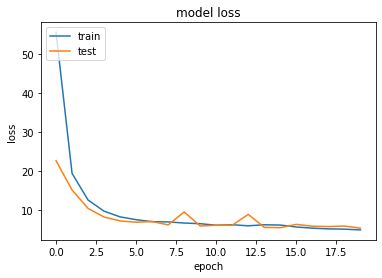 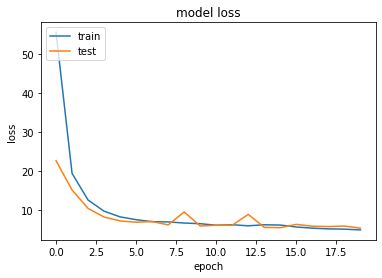